# Описание набора данных

Набор данных предназначен для принятия решений о посеве той или иной сельскохозяйственной культуры в зависимости от состава почвы и условий окружающей среды, чтобы обеспечить максимальную урожайность.


| Признак     | Описание                   |
|-------------|----------------------------|
| Nitrogen    | Содержание азота в почве   |
| Phosphorus  | Содержание фосфора в почве |
| Potassium   | Содержание калия в почве   |
| Temperature | Температура (℃)            |
| Humidity    | Влажность (%)              |
| pH_Value    | Уровень PH почвы           |
| Rainfall    | Осадки (мм)                |

Целевая переменная:
**Crop** - наиболее подходящая культура для выращивания.

# Предварительная обработка данных

Импортируем библиотеки

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

Загрузим данные в датафрейм

In [2]:
df = pd.read_csv('Crop_Recommendation.csv')
df

,Nitrogen,Phosphorus,Potassium,Temperature,Humidity,pH_Value,Rainfall,Crop
0,90,42,43,20.879744,82.002744,6.502985,202.935536,Rice
1,85,58,41,21.770462,80.319644,7.038096,226.655537,Rice
2,60,55,44,23.004459,82.320763,7.840207,263.964248,Rice
3,74,35,40,26.491096,80.158363,6.980401,242.864034,Rice
4,78,42,42,20.130175,81.604873,7.628473,262.717340,Rice
...,...,...,...,...,...,...,...,...
2195,107,34,32,26.774637,66.413269,6.780064,177.774507,Coffee
2196,99,15,27,27.417112,56.636362,6.086922,127.924610,Coffee
2197,118,33,30,24.131797,67.225123,6.362608,173.322839,Coffee
2198,117,32,34,26.272418,52.127394,6.758793,127.175293,Coffee


Проверим, есть ли в датасете пропуски или дубликаты

In [3]:
df.isnull().any()

Nitrogen       False
Phosphorus     False
Potassium      False
Temperature    False
Humidity       False
pH_Value       False
Rainfall       False
Crop           False
dtype: bool

In [4]:
df.duplicated().any()

False

В данных нет пропущенных или дублирующихся значений

Количество уникальных значений каждого столбца:

In [5]:
df.nunique()

Nitrogen        137
Phosphorus      117
Potassium        73
Temperature    2200
Humidity       2200
pH_Value       2200
Rainfall       2200
Crop             22
dtype: int64

Основные статистики:

In [6]:
df.describe()

,Nitrogen,Phosphorus,Potassium,Temperature,Humidity,pH_Value,Rainfall
count,2200.000000,2200.000000,2200.000000,2200.000000,2200.000000,2200.000000,2200.000000
mean,50.551818,53.362727,48.149091,25.616244,71.481779,6.469480,103.463655
std,36.917334,32.985883,50.647931,5.063749,22.263812,0.773938,54.958389
min,0.000000,5.000000,5.000000,8.825675,14.258040,3.504752,20.211267
25%,21.000000,28.000000,20.000000,22.769375,60.261953,5.971693,64.551686
50%,37.000000,51.000000,32.000000,25.598693,80.473146,6.425045,94.867624
75%,84.250000,68.000000,49.000000,28.561654,89.948771,6.923643,124.267508
max,140.000000,145.000000,205.000000,43.675493,99.981876,9.935091,298.560117


Проверим сбалансированность классов:

In [7]:
target = df['Crop']
target.value_counts()

Crop
Rice           100
Maize          100
Jute           100
Cotton         100
Coconut        100
Papaya         100
Orange         100
Apple          100
Muskmelon      100
Watermelon     100
Grapes         100
Mango          100
Banana         100
Pomegranate    100
Lentil         100
Blackgram      100
MungBean       100
MothBeans      100
PigeonPeas     100
KidneyBeans    100
ChickPea       100
Coffee         100
Name: count, dtype: int64

Классы абсолютно сбалансированы

 Построим гистограммы распределения признаков:

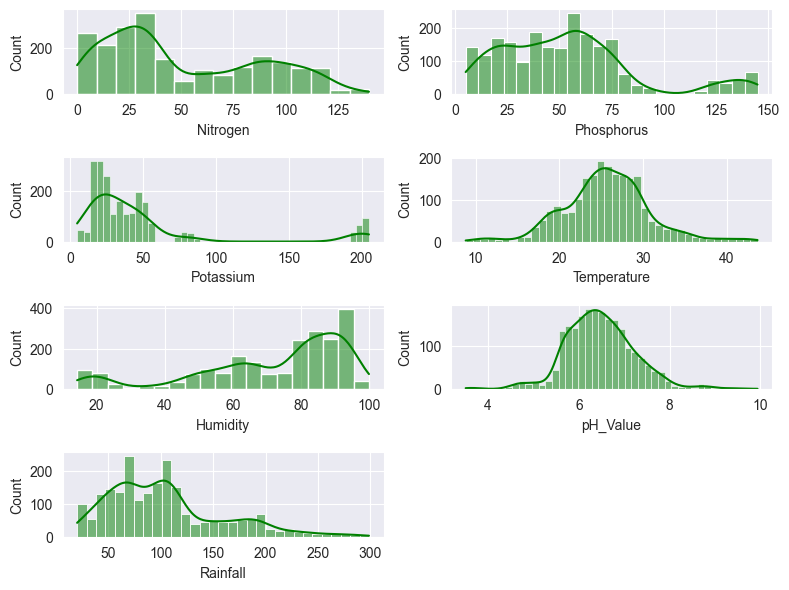

In [8]:
features = df.drop(columns='Crop')
feature_columns = features.columns

num_cols = 2
plt.figure(figsize=(8, 10))
for i, col in enumerate(feature_columns):
  plt.subplot(len(feature_columns), num_cols, i + 1)
  sns.histplot(data=features, x=col, kde=True, color='g')

plt.tight_layout()

Большинство признаков не соответствуют нормальному распределению (имеют право- или левостороннюю асимметрию)

Построим boxplot (ящики с усами):

<Axes: >

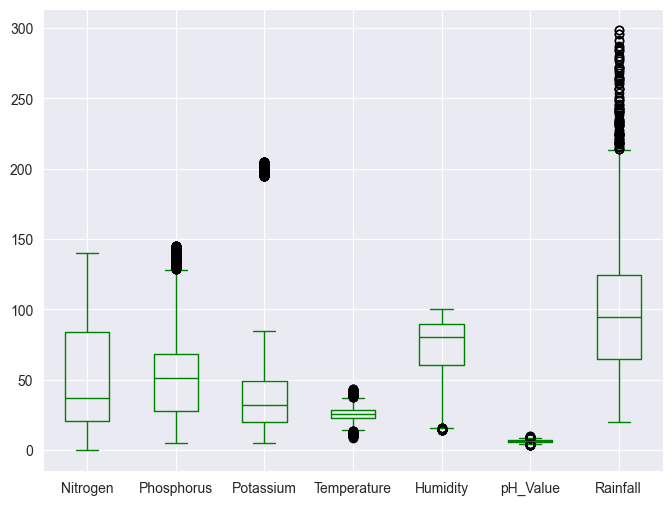

In [9]:
df.boxplot(figsize=(8, 6), color='g')

Видим, что в данных присутствуют некоторые выбросы, однако они не представляют "экстремально" аномальных значений. Напротив, такие данные могут нести ценную информацию о специфических условиях выращивания.

Также, очевидно, рассматриваемые величины имеют разный порядок. Проведем масштабирование числовых признаков с помощью `StandardScaler`

In [10]:
scaler = StandardScaler()
features = pd.DataFrame(scaler.fit_transform(features), columns=feature_columns)
features

,Nitrogen,Phosphorus,Potassium,Temperature,Humidity,pH_Value,Rainfall
0,1.068797,-0.344551,-0.101688,-0.935587,0.472666,0.043302,1.810361
1,0.933329,0.140616,-0.141185,-0.759646,0.397051,0.734873,2.242058
2,0.255986,0.049647,-0.081939,-0.515898,0.486954,1.771510,2.921066
3,0.635298,-0.556811,-0.160933,0.172807,0.389805,0.660308,2.537048
4,0.743673,-0.344551,-0.121436,-1.083647,0.454792,1.497868,2.898373
...,...,...,...,...,...,...,...
2195,1.529390,-0.587134,-0.318922,0.228814,-0.227709,0.401395,1.352437
2196,1.312641,-1.163269,-0.417666,0.355720,-0.666947,-0.494413,0.445183
2197,1.827421,-0.617457,-0.358420,-0.293218,-0.191235,-0.138120,1.271418
2198,1.800327,-0.647780,-0.279425,0.129612,-0.869518,0.373904,0.431545


Разделим набор данных на тестовую и обучающую выборки в соотношении `test_size=0.2`.

In [11]:
X_train, X_test, y_train, y_test = train_test_split(features, target, random_state=21)
print('Train:', X_train.shape, y_train.shape)
print('Test:', X_test.shape, y_test.shape)

Train: (1650, 7) (1650,)
Test: (550, 7) (550,)


Теперь данные подготовленны и можно идти дальше.

# Постановка задачи и построение модели

Наша задача - построить несколько моделей для классификации подходящей сельскохозяйственной культуры на основе данных об окружающей среде, а затем сравнить результаты и выбрать лучшую.

Начнем с метода **KNN** - `KNeighborsClassifier`. С помощью `GridSearchCV` подберем оптимальные параметры для модели (выбирать будем модель с лучшей `accuracy`).

In [12]:
parameter_grid = {
    'n_neighbors': np.arange(2, 30, 1),
    'p': [1, 2, 3]
}

knn = GridSearchCV(estimator=KNeighborsClassifier(),
                             param_grid=parameter_grid,
                             cv=5,
                             scoring='accuracy',
                             n_jobs=-1
                            )

In [13]:
knn.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'n_neighbors': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]),
                         'p': [1, 2, 3]},
             scoring='accuracy')

In [14]:
knn.best_params_

{'n_neighbors': 5, 'p': 1}

Лучшие результаты модель дает при 5 ближайших соседях и параметре мощности 1. Посмотрим точность предсказания на тренировочных данных и сделаем предсказание для тестовых.

In [15]:
accuracy_score(y_train, knn.best_estimator_.predict(X_train))

0.990909090909091

In [16]:
knn_prediction = knn.best_estimator_.predict(X_test)

Попробуем также построить модель **Дерева решений** - `DecisionTreeClassifier`.

In [17]:
parameter_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [50, 20, 15],
    'min_samples_split': [2, 7, 10],
    'min_samples_leaf': [1, 2, 3]
}

tree = GridSearchCV(estimator=DecisionTreeClassifier(random_state=21),
                             param_grid=parameter_grid,
                             cv=5,
                             scoring='accuracy',
                             n_jobs=-1
                            )

In [18]:
tree.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=21), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [50, 20, 15],
                         'min_samples_leaf': [1, 2, 3],
                         'min_samples_split': [2, 7, 10]},
             scoring='accuracy')

Лучшие параметры для модели:

In [19]:
tree.best_params_

{'criterion': 'gini',
 'max_depth': 50,
 'min_samples_leaf': 2,
 'min_samples_split': 7}

In [20]:
accuracy_score(y_train, tree.best_estimator_.predict(X_train))

0.996969696969697

In [21]:
tree_prediction = tree.predict(X_test)

Наконец, построим ансамблевую модель **Случайного леса** - `RandomForestClassifier`.

In [22]:
parameter_grid = {
    'n_estimators': [100,300,500],
    'max_depth': [50, 20, 15],
    'min_samples_split': [2, 7, 10],
    'min_samples_leaf': [1,2,3]
}

forest = GridSearchCV(estimator=RandomForestClassifier(random_state=21),
                                param_grid=parameter_grid,
                                cv=5,
                                scoring='accuracy',
                                n_jobs=-1
                              )

In [23]:
forest.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=21), n_jobs=-1,
             param_grid={'max_depth': [50, 20, 15],
                         'min_samples_leaf': [1, 2, 3],
                         'min_samples_split': [2, 7, 10],
                         'n_estimators': [100, 300, 500]},
             scoring='accuracy')

Лучшие параметры:

In [24]:
forest.best_params_

{'max_depth': 50,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 100}

In [25]:
accuracy_score(y_train, forest.best_estimator_.predict(X_train))

1.0

In [26]:
forest_prediction = forest.best_estimator_.predict(X_test)

# Оценка модели и результатов

Рассмотрим `classification_report` моделей для предсказаний, выполненных на тестовых данных:

**Модель k-ближайших соседей:**

In [27]:
print(classification_report(y_test, knn_prediction, digits=3))

              precision    recall  f1-score   support

       Apple      1.000     1.000     1.000        22
      Banana      1.000     1.000     1.000        23
   Blackgram      0.935     1.000     0.967        29
    ChickPea      1.000     1.000     1.000        25
     Coconut      1.000     1.000     1.000        24
      Coffee      1.000     1.000     1.000        29
      Cotton      1.000     1.000     1.000        21
      Grapes      1.000     1.000     1.000        29
        Jute      0.909     0.968     0.938        31
 KidneyBeans      0.958     1.000     0.979        23
      Lentil      0.929     0.929     0.929        28
       Maize      1.000     1.000     1.000        21
       Mango      0.917     1.000     0.957        22
   MothBeans      1.000     0.871     0.931        31
    MungBean      1.000     1.000     1.000        30
   Muskmelon      1.000     1.000     1.000        23
      Orange      1.000     0.958     0.979        24
      Papaya      1.000    

**Дерево решений:**

In [28]:
print(classification_report(y_test, tree_prediction, digits=3))

              precision    recall  f1-score   support

       Apple      1.000     1.000     1.000        22
      Banana      0.958     1.000     0.979        23
   Blackgram      1.000     0.897     0.945        29
    ChickPea      1.000     1.000     1.000        25
     Coconut      1.000     1.000     1.000        24
      Coffee      0.967     1.000     0.983        29
      Cotton      0.955     1.000     0.977        21
      Grapes      1.000     1.000     1.000        29
        Jute      0.931     0.871     0.900        31
 KidneyBeans      1.000     1.000     1.000        23
      Lentil      1.000     1.000     1.000        28
       Maize      0.952     0.952     0.952        21
       Mango      1.000     1.000     1.000        22
   MothBeans      0.939     1.000     0.969        31
    MungBean      1.000     0.933     0.966        30
   Muskmelon      1.000     1.000     1.000        23
      Orange      1.000     1.000     1.000        24
      Papaya      1.000    

**Случайный лес:**

In [29]:
print(classification_report(y_test, forest_prediction, digits=3))

              precision    recall  f1-score   support

       Apple      1.000     1.000     1.000        22
      Banana      1.000     1.000     1.000        23
   Blackgram      1.000     0.966     0.982        29
    ChickPea      1.000     1.000     1.000        25
     Coconut      1.000     1.000     1.000        24
      Coffee      1.000     1.000     1.000        29
      Cotton      1.000     1.000     1.000        21
      Grapes      1.000     1.000     1.000        29
        Jute      0.939     1.000     0.969        31
 KidneyBeans      1.000     1.000     1.000        23
      Lentil      1.000     1.000     1.000        28
       Maize      0.955     1.000     0.977        21
       Mango      1.000     1.000     1.000        22
   MothBeans      1.000     1.000     1.000        31
    MungBean      1.000     1.000     1.000        30
   Muskmelon      1.000     1.000     1.000        23
      Orange      1.000     1.000     1.000        24
      Papaya      1.000    

Итак, мы получили следующие результаты точности моделей:

| Модель              | Точность |
|---------------------|----------|
| K-Nearest neighbors | 97.8%    |
| Decision tree       | 97.5%    |
| Random forest       | 99.5%    |

Таким образом, лучшие результаты имеет модель случайного леса - она показала очень высокую точность, практически идеально классифицируя все культуры.